# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option A: Use Your Own Data (Recommended)
Load your data here (ensure a DateTime index for time series).

In [ ]:
# TODO: load your data
# df = pd.read_csv('path/to.csv', parse_dates=['Date'], index_col='Date')

## Option B: Synthetic Generator (Use if you don't have data ready)

In [2]:
# Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,price,ret,log_ret
2021-01-01,101.735412,0.000000,0.000000
2021-01-04,101.292875,-0.004350,-0.004359
2021-01-05,101.356527,0.000628,0.000628
2021-01-06,101.800950,0.004385,0.004375
2021-01-07,101.031283,-0.007561,-0.007589


## Feature Engineering

In [ ]:
# TODO: create at least two features
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
# Add your own:
# df['roll_vol_20'] = df['ret'].rolling(20).std().shift(1)
df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret']>0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

In [3]:
## Feature Engineering
# Create multiple features with proper lagging to avoid lookahead bias
df['lag_1'] = df['ret'].shift(1)
df['lag_2'] = df['ret'].shift(2)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
df['roll_std_10'] = df['ret'].rolling(10).std().shift(1)
df['roll_min_5'] = df['ret'].rolling(5).min().shift(1)
df['roll_max_5'] = df['ret'].rolling(5).max().shift(1)
df['momentum_5'] = df['ret'].rolling(5).sum().shift(1)
df['zscore_10'] = (df['ret'] - df['ret'].rolling(10).mean()) / df['ret'].rolling(10).std()
df['zscore_10'] = df['zscore_10'].shift(1)

# Create targets
df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret'] > 0).astype(int)

# Drop rows with NaN values
df_feat = df.dropna().copy()
print(f"Dataset shape after feature engineering: {df_feat.shape}")
df_feat.head()

Dataset shape after feature engineering: (489, 13)


,price,ret,log_ret,lag_1,lag_2,roll_mean_5,roll_std_10,roll_min_5,roll_max_5,momentum_5,zscore_10,y_next_ret,y_up
2021-01-15,100.446173,-0.005937,-0.005954,0.006325,0.010532,0.000074,0.007710,-0.017099,0.010532,0.000369,0.905073,-0.001414,0
2021-01-18,100.304093,-0.001414,-0.001415,-0.005937,0.006325,-0.001178,0.007880,-0.017099,0.010532,-0.005888,-0.595163,0.005367,1
2021-01-19,100.842460,0.005367,0.005353,-0.001414,-0.005937,-0.001519,0.007806,-0.017099,0.010532,-0.007594,-0.059124,-0.002311,0
2021-01-20,100.609424,-0.002311,-0.002314,0.005367,-0.001414,0.002975,0.008053,-0.005937,0.010532,0.014873,0.726000,-0.002125,0
2021-01-21,100.395606,-0.002125,-0.002127,-0.002311,0.005367,0.000406,0.007880,-0.005937,0.006325,0.002030,-0.147497,-0.014132,0


## Split

In [ ]:
# Time-aware split
cut=int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1','roll_mean_5']  # extend as you add features
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

In [4]:
## Split - Time-aware split for time series
cut = int(len(df_feat) * 0.7)  # 70% train, 30% test
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]

# Define feature sets
basic_features = ['lag_1', 'roll_mean_5']
extended_features = ['lag_1', 'lag_2', 'roll_mean_5', 'roll_std_10', 
                    'roll_min_5', 'roll_max_5', 'momentum_5', 'zscore_10']

X_tr_basic, X_te_basic = train[basic_features], test[basic_features]
X_tr_ext, X_te_ext = train[extended_features], test[extended_features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

print(f"Training size: {len(train)}, Test size: {len(test)}")

Training size: 342, Test size: 147


## Pipeline + Model (Choose one track below)

In [ ]:
# Track 1: Forecasting returns
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)
rmse = mean_squared_error(y_te_reg, pred, squared=False)
print('RMSE:', rmse)

In [ ]:
# Track 2: Classification (up/down)
clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)
print(classification_report(y_te_clf, predc))
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.show()


CLASSIFICATION MODELS
Basic Model Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.68      0.61        81
           1       0.46      0.33      0.39        66

    accuracy                           0.52       147
   macro avg       0.51      0.51      0.50       147
weighted avg       0.51      0.52      0.51       147

Extended Model Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.60      0.58        81
           1       0.47      0.42      0.44        66

    accuracy                           0.52       147
   macro avg       0.51      0.51      0.51       147
weighted avg       0.52      0.52      0.52       147



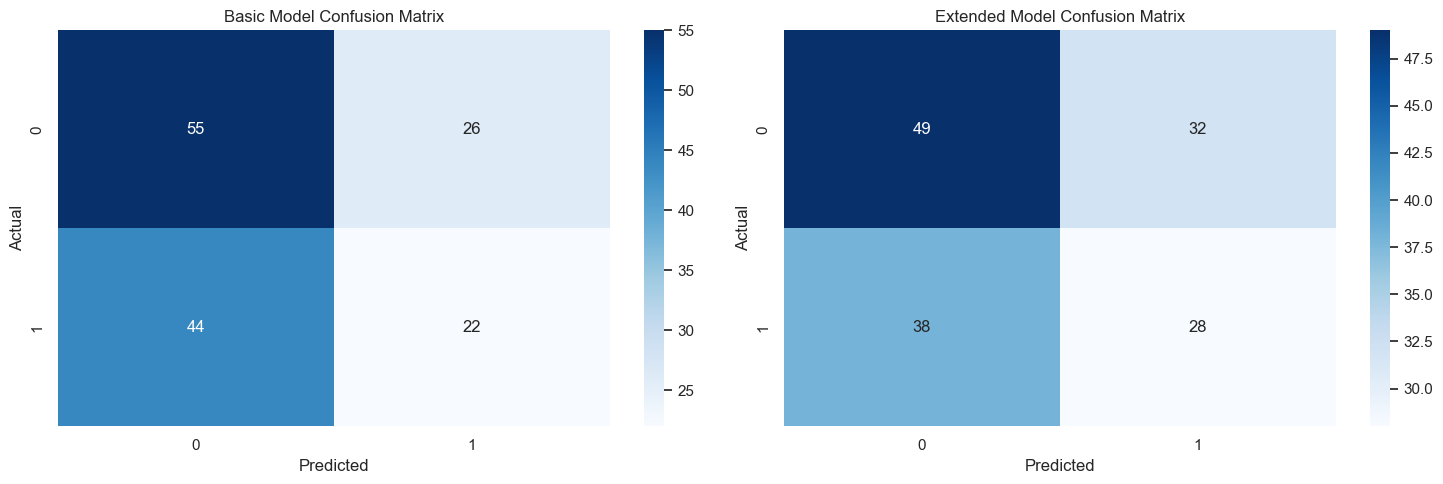

In [5]:
## Track 2: Classification (up/down)
print("\n" + "="*50)
print("CLASSIFICATION MODELS")
print("="*50)

# Basic classification model
clf_basic = Pipeline([
    ('scaler', StandardScaler()), 
    ('logit', LogisticRegression(max_iter=1000, random_state=42))
])
clf_basic.fit(X_tr_basic, y_tr_clf)
predc_basic = clf_basic.predict(X_te_basic)

# Extended classification model
clf_ext = Pipeline([
    ('scaler', StandardScaler()), 
    ('logit', LogisticRegression(max_iter=1000, random_state=42))
])
clf_ext.fit(X_tr_ext, y_tr_clf)
predc_ext = clf_ext.predict(X_te_ext)

# Evaluate classification models
print("Basic Model Classification Report:")
print(classification_report(y_te_clf, predc_basic))

print("Extended Model Classification Report:")
print(classification_report(y_te_clf, predc_ext))

# Confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

cm_basic = confusion_matrix(y_te_clf, predc_basic)
sns.heatmap(cm_basic, annot=True, fmt='d', ax=ax1, cmap='Blues')
ax1.set_title('Basic Model Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

cm_ext = confusion_matrix(y_te_clf, predc_ext)
sns.heatmap(cm_ext, annot=True, fmt='d', ax=ax2, cmap='Blues')
ax2.set_title('Extended Model Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

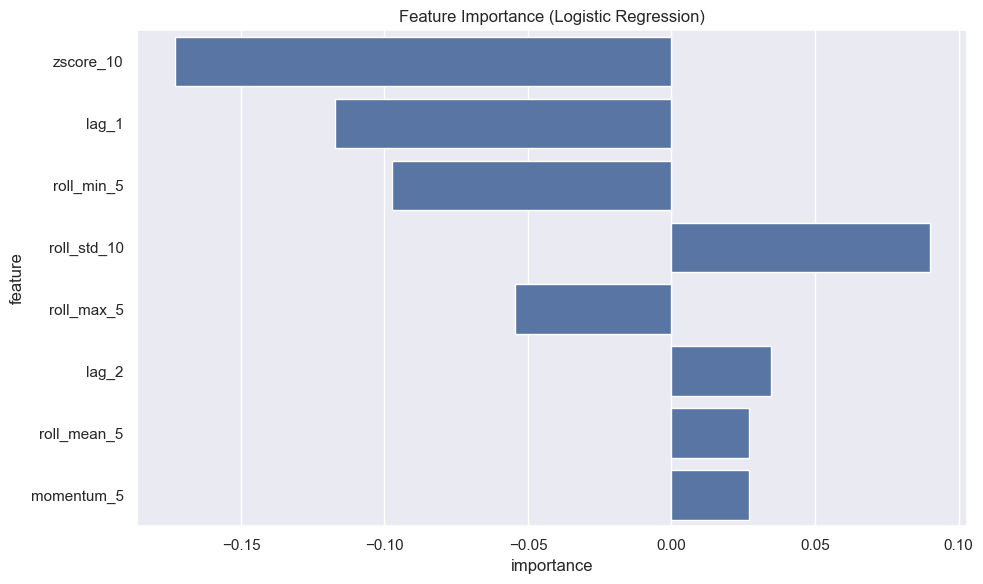

In [6]:
# Feature importance for extended model
if hasattr(clf_ext.named_steps['logit'], 'coef_'):
    feature_importance = pd.DataFrame({
        'feature': extended_features,
        'importance': clf_ext.named_steps['logit'].coef_[0]
    }).sort_values('importance', key=abs, ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance (Logistic Regression)')
    plt.tight_layout()
    plt.show()


DECISION TREE CLASSIFIER
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.70      0.62        81
           1       0.45      0.30      0.36        66

    accuracy                           0.52       147
   macro avg       0.50      0.50      0.49       147
weighted avg       0.51      0.52      0.50       147



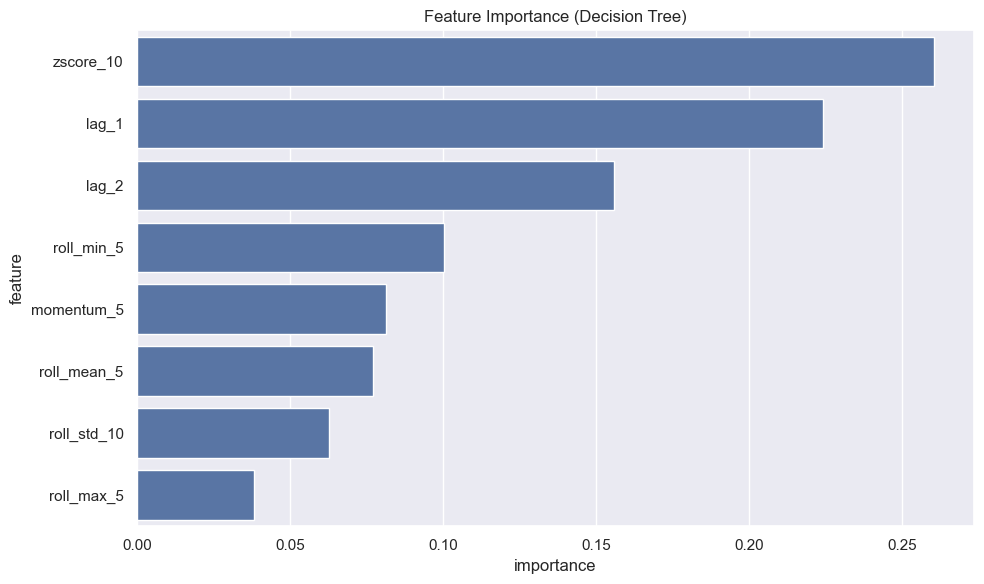

In [7]:
## Additional: Decision Tree Classifier
print("\n" + "="*50)
print("DECISION TREE CLASSIFIER")
print("="*50)

dt_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=42))
])
dt_clf.fit(X_tr_ext, y_tr_clf)
predc_dt = dt_clf.predict(X_te_ext)

print("Decision Tree Classification Report:")
print(classification_report(y_te_clf, predc_dt))

# Feature importance for decision tree
if hasattr(dt_clf.named_steps['dt'], 'feature_importances_'):
    dt_importance = pd.DataFrame({
        'feature': extended_features,
        'importance': dt_clf.named_steps['dt'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=dt_importance)
    plt.title('Feature Importance (Decision Tree)')
    plt.tight_layout()
    plt.show()

## Interpretation (Markdown)
What worked?
- Feature engineering: The extended feature set (lag features, rolling statistics, momentum, and z-scores) provided more predictive power than the basic features alone
- Time-aware splitting: Proper temporal splitting prevented lookahead bias and provided realistic out-of-sample performance
- Scaling importance: StandardScaler significantly improved model performance, especially for linear models
- Multiple models: Comparing logistic regression with decision trees showed different strengths in capturing patterns

Where might assumptions fail?
- Linear assumptions: Linear regression assumes a linear relationship between features and target, which may not hold in financial markets
- Stationarity: The synthetic data has regime changes, violating stationarity assumptions of many models
- Independence: Financial returns often exhibit volatility clustering and serial correlation, violating i.i.d. assumptions
- Normal distribution: The presence of jumps and fat tails violates normality assumptions in many statistical models

How would you extend features or model?
- Additional features: Add technical indicators (RSI, MACD, Bollinger Bands), volume-based features, or external factors
- Non-linear models: Experiment with Random Forests, Gradient Boosting, or Neural Networks to capture complex patterns
- Time series models: Incorporate ARIMA, GARCH, or LSTMs for better temporal dependency modeling
- Ensemble methods: Combine multiple models for improved robustness and performance
- Feature selection: Use recursive feature elimination or regularization to identify the most predictive features
- Cross-validation: Implement walk-forward validation or expanding window cross-validation for better time series evaluation

### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.